## Where do embeddings come from?
### Embedding MNIST images and NLP sentences into vectors.


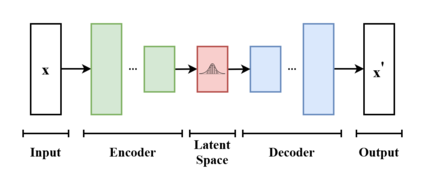

[Source](https://en.wikipedia.org/wiki/Variational_autoencoder)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import losses
from scipy.stats import norm

2024-01-23 07:03:32.571277: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-23 07:03:32.634825: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-23 07:03:32.634882: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-23 07:03:32.634919: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-23 07:03:32.645348: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-23 07:03:32.646172: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
# Load data – training and test
(x_tr, y_tr), (x_te, y_te) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
x_tr.shape

(60000, 28, 28)

In [4]:
x_tr[0].shape

(28, 28)

Every digit is represented as 28x28 dimensions.

In [5]:
#Normalize and Reshape images (flatten)
x_tr, x_te = x_tr.astype('float32')/255., x_te.astype('float32')/255.
x_tr_flat, x_te_flat = x_tr.reshape(x_tr.shape[0], -1), x_te.reshape(x_te.shape[0], -1)

In [7]:
print('Shape before Normalizing: ', x_tr.shape, x_te.shape)
print('Shape after Normalizing: ', x_tr_flat.shape, x_te_flat.shape)

Shape before Normalizing:  (60000, 28, 28) (10000, 28, 28)
Shape after Normalizing:  (60000, 784) (10000, 784)


In [8]:
# Neural Network Parameters
batch_size, n_epoch = 100, 50
n_hidden, z_dim = 256, 2

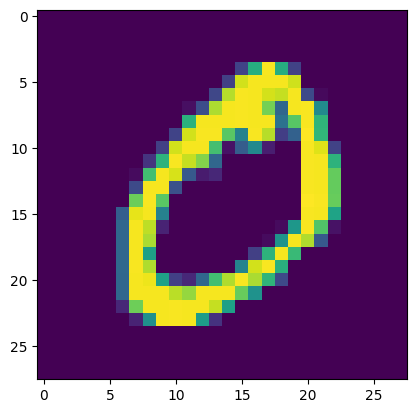

In [9]:
# Example of a training image
plt.imshow(x_tr[1]);

In [10]:
# sampling function
def sampling(args):
    mu, log_var = args
    eps = K.random_normal(shape=(batch_size, z_dim), mean=0., stddev=1.0)
    return mu + K.exp(log_var) * eps

In [11]:
# Encoder - from 784->256->128->2
inputs_flat = Input(shape=(x_tr_flat.shape[1:]))
x_flat = Dense(n_hidden, activation='relu')(inputs_flat) # first hidden layer
x_flat = Dense(n_hidden//2, activation='relu')(x_flat)  # second hidden layer

# hidden state, which we will pass into the Model to get the Encoder.
mu_flat = Dense(z_dim)(x_flat)
log_var_flat = Dense(z_dim)(x_flat)
z_flat = Lambda(sampling, output_shape=(z_dim,))([mu_flat, log_var_flat])

In [12]:
#Decoder - from 2->128->256->784
latent_inputs = Input(shape=(z_dim,))
z_decoder1 = Dense(n_hidden//2, activation='relu')
z_decoder2 = Dense(n_hidden, activation='relu')
y_decoder = Dense(x_tr_flat.shape[1], activation='sigmoid')
z_decoded = z_decoder1(latent_inputs)
z_decoded = z_decoder2(z_decoded)
y_decoded = y_decoder(z_decoded)
decoder_flat = Model(latent_inputs, y_decoded, name="decoder_conv")

outputs_flat = decoder_flat(z_flat)

In [13]:
# variational autoencoder (VAE) - to reconstruction input
reconstruction_loss = losses.binary_crossentropy(inputs_flat,
                                                 outputs_flat) * x_tr_flat.shape[1]
kl_loss = 0.5 * K.sum(K.square(mu_flat) + K.exp(log_var_flat) - log_var_flat - 1, axis = -1)
vae_flat_loss = reconstruction_loss + kl_loss

# Build model
#  Ensure that the reconstructed outputs are as close to the inputs
vae_flat = Model(inputs_flat, outputs_flat)
vae_flat.add_loss(vae_flat_loss)
vae_flat.compile(optimizer='adam')

In [14]:
# train
vae_flat.fit(
    x_tr_flat,
    shuffle=True,
    epochs=n_epoch,
    batch_size=batch_size,
    validation_data=(x_te_flat, None),
    verbose=1
)

Epoch 1/50
600/600 [==============================] - 12s 17ms/step - loss: 201.0638 - val_loss: 173.2460
Epoch 2/50
600/600 [==============================] - 10s 16ms/step - loss: 166.6539 - val_loss: 160.7010
Epoch 3/50
600/600 [==============================] - 9s 16ms/step - loss: 158.1944 - val_loss: 155.0514
Epoch 4/50
600/600 [==============================] - 10s 17ms/step - loss: 153.9174 - val_loss: 151.7157
Epoch 5/50
600/600 [==============================] - 10s 17ms/step - loss: 151.2581 - val_loss: 150.1035
Epoch 6/50
600/600 [==============================] - 10s 17ms/step - loss: 149.5504 - val_loss: 148.6678
Epoch 7/50
600/600 [==============================] - 10s 17ms/step - loss: 148.3134 - val_loss: 148.1867
Epoch 8/50
600/600 [==============================] - 10s 17ms/step - loss: 147.1150 - val_loss: 146.7593
Epoch 9/50
600/600 [==============================] - 10s 17ms/step - loss: 146.4752 - val_loss: 146.3791
Epoch 10/50
600/600 [==========================

### Visualize Embeddings

In [15]:
# Build encoders
encoder_f = Model(inputs_flat, z_flat)  # flat encoder

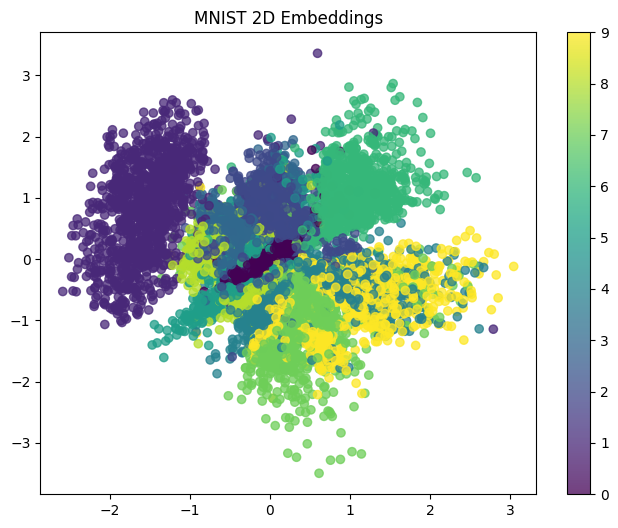

In [16]:
# Plot of the digit classes in the latent space
x_te_latent = encoder_f.predict(x_te_flat, batch_size=batch_size,verbose=0)
plt.figure(figsize=(8, 6))
plt.scatter(x_te_latent[:, 0], x_te_latent[:, 1], c=y_te, alpha=0.75)
plt.title('MNIST 2D Embeddings')
plt.colorbar()
plt.show()

## Example: compare three embeddings

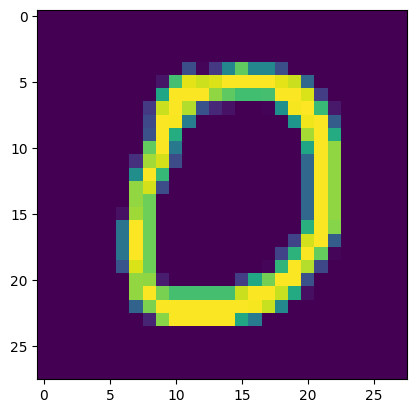

In [17]:
plt.imshow(x_te_flat[10].reshape(28,28));

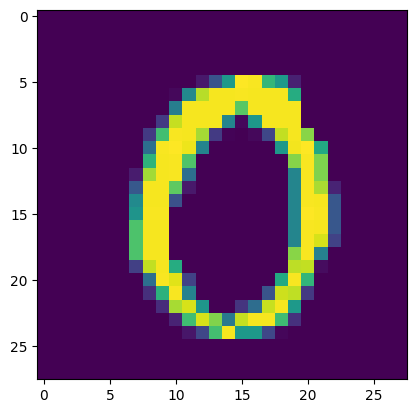

In [18]:
plt.imshow(x_te_flat[13].reshape(28,28));

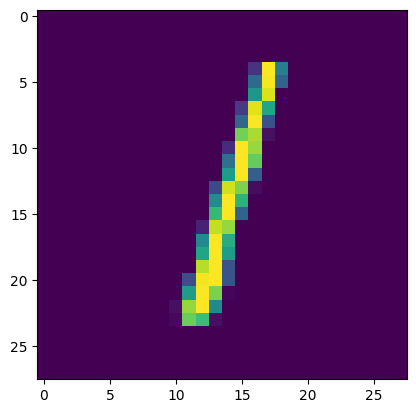

In [19]:
plt.imshow(x_te_flat[2].reshape(28,28));

In [20]:
# calculate vectors for each digit
zero_A = x_te_latent[10]
zero_B = x_te_latent[13]
one = x_te_latent[2]

print(f"Embedding for the first ZERO is  {zero_A}")
print(f"Embedding for the second ZERO is {zero_B}")
print(f"Embedding for the ONE is         {one}")

Embedding for the first ZERO is  [-0.08024848  0.03735347]
Embedding for the second ZERO is [-0.12655565  0.05815591]
Embedding for the ONE is         [-2.085944   0.8239068]


## Using more advanced models based on the Transformer architechture you can embed sentences aswell.

In [21]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [22]:
#Sentences we want to encode. Example:
sentence = ['The team enjoyed the hike through the meadow',
            'The national park had great views',
            'Olive oil drizzled over pizza tastes delicious']

In [23]:
#Sentences are encoded by calling model.encode()
embedding = model.encode(sentence)

#Preview the embeddings
print(embedding)

[[ 0.3706197   0.2641425   0.21265654 ...  0.14994532 -0.2579492
  -0.2397075 ]
 [ 0.66933304  0.40094963 -0.48208407 ...  0.10645866 -1.5067165
  -0.01547357]
 [-0.2655591   0.11172403 -0.14733036 ...  0.42197466  0.88394594
   0.10763935]]


In [24]:
embedding.shape

(3, 384)

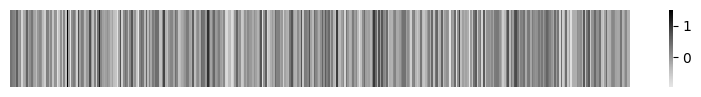

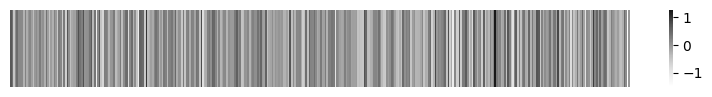

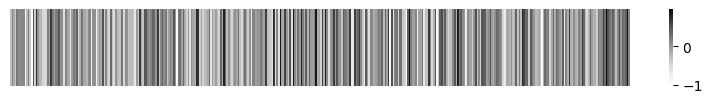

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(embedding[0].reshape(-1,384),cmap="Greys",center=0,square=False)
plt.gcf().set_size_inches(10,1)
plt.axis('off')
plt.show()

sns.heatmap(embedding[1].reshape(-1,384),cmap="Greys",center=0,square=False)
plt.gcf().set_size_inches(10,1)
plt.axis('off')
plt.show()

sns.heatmap(embedding[2].reshape(-1,384),cmap="Greys",center=0,square=False)
plt.gcf().set_size_inches(10,1)
plt.axis('off')
plt.show()

## How can we measure the distance between these Image and Sentence Embeddings?

There are many ways to calculate the distances between two vectors.

Here we will cover 4 distance metrics that you might find being used in the context of vector databases:
- Euclidean Distance(L2)
- Manhattan Distance(L1)
- Dot Product
- Cosine Distance

### Euclidean Distance(L2)
The length of the shortest path between two points or vectors.

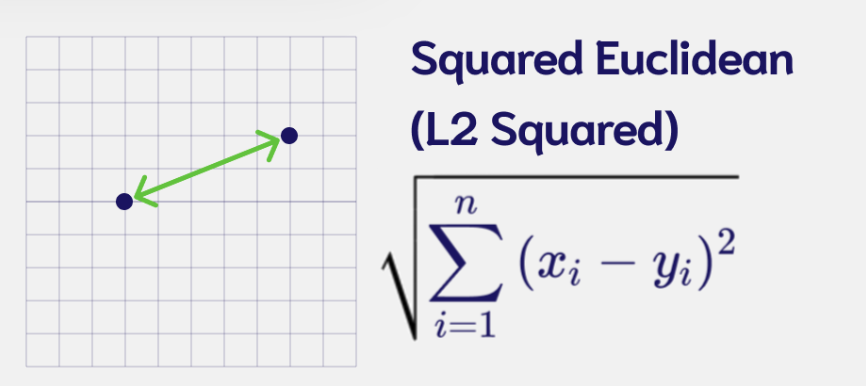

In [29]:
# Euclidean Distance
#find distance between images of zero and zero
L2 = [(zero_A[i] - zero_B[i])**2 for i in range(len(zero_A))]
L2 = np.sqrt(np.array(L2).sum())
print(L2)

0.05076510104528116


Using built in numpy method:

In [32]:
#An alternative way of doing this
np.linalg.norm((zero_A - zero_B), ord=2)

0.0507651

In [33]:
#Calculate L2 distances
print("Distance zeroA-zeroB:", np.linalg.norm((zero_A - zero_B), ord=2))
print("Distance zeroA-one:  ", np.linalg.norm((zero_A - one), ord=2))
print("Distance zeroB-one:  ", np.linalg.norm((zero_B - one), ord=2))

Distance zeroA-zeroB: 0.0507651
Distance zeroA-one:   2.1544094
Distance zeroB-one:   2.1037054


So the distance between zero and zero image is less and on the otherhand distance between zero image and image of one is greater.

### Manhattan Distance(L1)
Distance between two points if one was constrained to move only along one axis at a time.

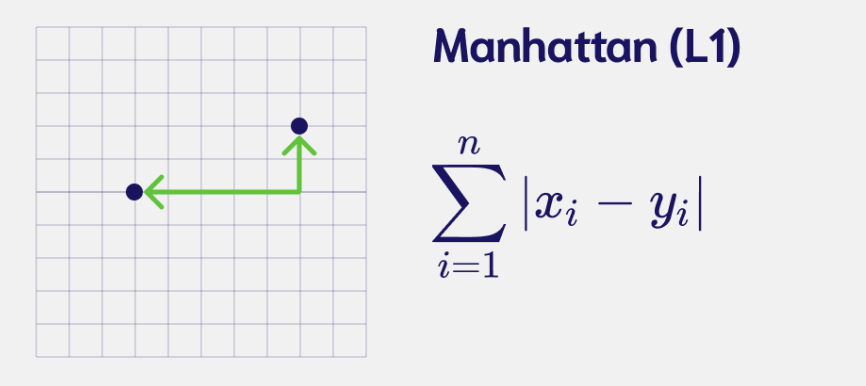

In [34]:
# Manhattan Distance
L1 = [zero_A[i] - zero_B[i] for i in range(len(zero_A))]
L1 = np.abs(L1).sum()

print(L1)

0.067109615


In [35]:
#an alternative way of doing this is
np.linalg.norm((zero_A - zero_B), ord=1)

0.067109615

In [36]:
#Calculate L1 distances
print("Distance zeroA-zeroB:", np.linalg.norm((zero_A - zero_B), ord=1))
print("Distance zeroA-one:  ", np.linalg.norm((zero_A - one), ord=1))
print("Distance zeroB-one:  ", np.linalg.norm((zero_B - one), ord=1))

Distance zeroA-zeroB: 0.067109615
Distance zeroA-one:   2.7922487
Distance zeroB-one:   2.7251391


### Dot Product
Measures the magnitude of the projection of one vector onto the other.

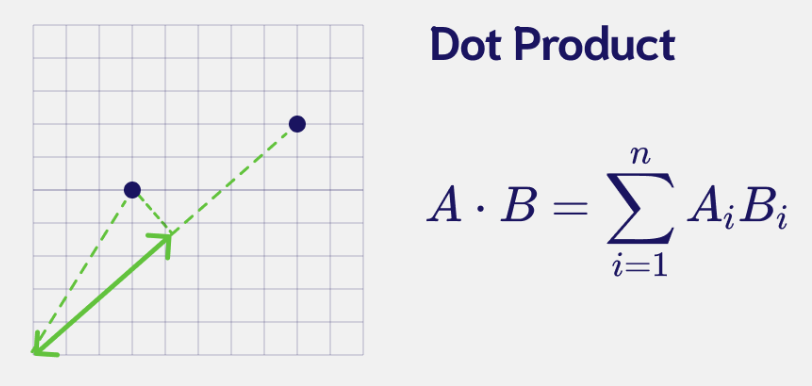

In [37]:
# Dot Product
np.dot(zero_A,zero_B)

0.012328223

In [38]:
#Calculate Dot products
print("Distance zeroA-zeroB:", np.dot(zero_A, zero_B))
print("Distance zeroA-one:  ", np.dot(zero_A, one))
print("Distance zeroB-one:  ", np.dot(zero_B, one))

Distance zeroA-zeroB: 0.012328223
Distance zeroA-one:   0.1981696
Distance zeroB-one:   0.31190303


### Cosine Distance
Measure the difference in directionality between vectors.

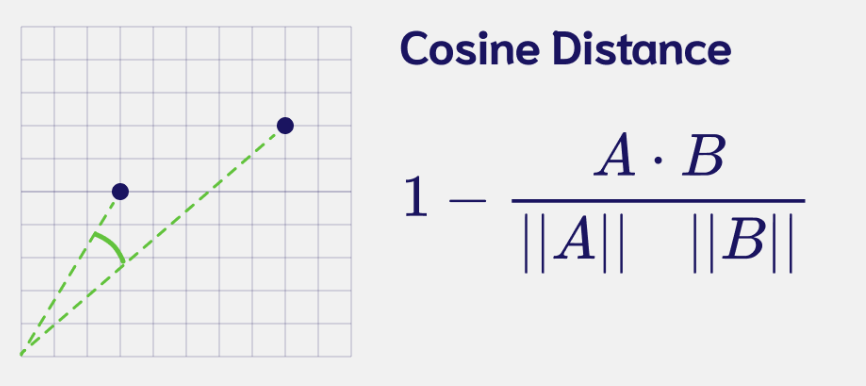

In [39]:
# Cosine Distance
cosine = 1 - np.dot(zero_A,zero_B)/(np.linalg.norm(zero_A)*np.linalg.norm(zero_B))
print(f"{cosine:.6f}")

0.000012


In [40]:
zero_A/zero_B

array([0.6340964 , 0.64229876], dtype=float32)

In [41]:
# Cosine Distance function
def cosine_distance(vec1,vec2):
  cosine = 1 - (np.dot(vec1, vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2)))
  return cosine

In [42]:
#Cosine Distance
print(f"Distance zeroA-zeroB: {cosine_distance(zero_A, zero_B): .6f}")
print(f"Distance zeroA-one:   {cosine_distance(zero_A, one): .6f}")
print(f"Distance zeroB-one:   {cosine_distance(zero_B, one): .6f}")

Distance zeroA-zeroB:  0.000012
Distance zeroA-one:    0.001768
Distance zeroB-one:    0.001489


Small angle value between zero and zero and relatively large angle value between zero and one.

## Now with the sentence embeddings!

Dot Product and Cosine Distance are commonly used in the field of NLP, to evaluate how similar two sentence embeddings are.
So here we will only use those two.

- embedding0 - 'The team enjoyed the hike through the meadow'

- embedding1 - The national park had great views'

- embedding2 - 'Olive oil drizzled over pizza tastes delicious'

In [43]:
#Dot Product
print("Distance 0-1:", np.dot(embedding[0], embedding[1]))
print("Distance 0-2:", np.dot(embedding[0], embedding[2]))
print("Distance 1-2:", np.dot(embedding[1], embedding[2]))

Distance 0-1: 26.49789
Distance 0-2: 2.0785775
Distance 1-2: 4.0192113


Dot product of first two sentence embeddings is high so that mean they are related as dot product measures magnitude of one on other.

And rest of sentences are not related shown by small score.

In [44]:
#Cosine Distance
print("Distance 0-1: ", cosine_distance(embedding[0], embedding[1]))
print("Distance 0-2: ", cosine_distance(embedding[0], embedding[2]))
print("Distance 1-2: ", cosine_distance(embedding[1], embedding[2]))

Distance 0-1:  0.5350335538387299
Distance 0-2:  0.9639393128454685
Distance 1-2:  0.9288790971040726


There is relatively small angle between vector 0 and 1 which shows relations.